In [1]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
X_train.shape

(50000, 32, 32, 3)

In [3]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0


In [5]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

In [7]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [9]:
batch_X, batch_y = next(datagen.flow(X_train, y_train, batch_size=32))
print(f"Batch X shape: {batch_X.shape}, Batch y shape: {batch_y.shape}")

Batch X shape: (32, 32, 32, 3), Batch y shape: (32, 10)


In [10]:
def f1_score(y_true, y_pred):
    y_true = K.cast(K.argmax(y_true, axis=-1), 'float32')  # Convert to float32
    y_pred = K.cast(K.argmax(y_pred, axis=-1), 'float32')  # Convert to float32
    
    tp = K.sum(K.cast(K.equal(y_true, y_pred) & K.equal(y_true, 1), 'float32'))  # True positives
    fp = K.sum(K.cast(K.equal(y_true, 0) & K.equal(y_pred, 1), 'float32'))  # False positives
    fn = K.sum(K.cast(K.equal(y_true, 1) & K.equal(y_pred, 0), 'float32'))  # False negatives

    precision = tp / (tp + fp + K.epsilon())  # Avoid division by zero
    recall = tp / (tp + fn + K.epsilon())  # Avoid division by zero
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1 score calculation
    
    return f1


In [11]:
def create_model():
    cnn = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.23),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.23),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.23),

        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Increased complexity
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Output matches the one-hot encoding
    ])

    cnn.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Explicit learning rate
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            f1_score
        ]
    )
    return cnn

In [12]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models, layers
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np


In [13]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [14]:
y_train_class = np.argmax(y_train, axis=1)

In [15]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(X_train, y_train_class)):
    print(f"Training fold {fold + 1}...")

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...


In [18]:
X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]

In [19]:
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import l2
import tensorflow as tf
cnn = create_model()

Training fold 1...
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 65s 64ms/step - accuracy: 0.2438 - f1_score: 0.5308 - loss: 2.9827 - precision: 0.3618 - recall: 0.0510 - val_accuracy: 0.3147 - val_f1_score: 0.5508 - val_loss: 2.5401 - val_precision: 0.4974 - val_recall: 0.1437 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.3654 - f1_score: 0.6985 - loss: 2.2595 - precision: 0.5659 - recall: 0.1337 - val_accuracy: 0.5100 - val_f1_score: 0.8699 - val_loss: 1.7901 - val_precision: 0.7182 - val_recall: 0.3144 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.4208 - f1_score: 0.7306 - loss: 2.0047 - precision: 0.6122 - recall: 0.1985 - val_accuracy: 0.4453 - val_f1_score: 0.8422 - val_loss: 2.0677 - val_precision: 0.5640 - val_recall: 0.3568 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.4847 - f1_score: 0.8239 - loss: 1.8465 - precision: 0.6711 - recall: 0.2822 - val_accuracy: 0.4686 - 

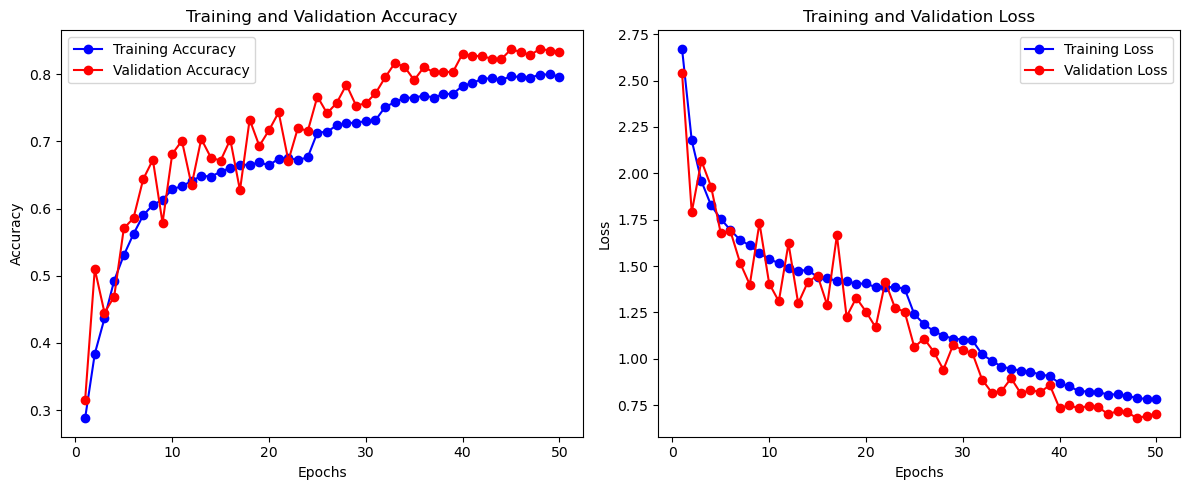

Test Loss: 0.691506564617157
Test Accuracy: 0.8324999809265137
Test Precision: 0.8728619813919067
Test Recall: 0.8011999726295471
Test F1-score: 0.9509038329124451


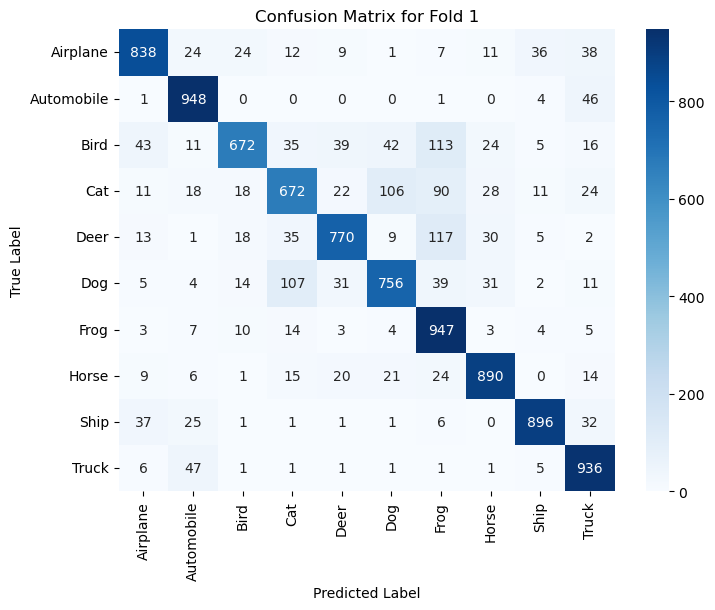

Classification Report for Fold 1:
              precision    recall  f1-score   support

    Airplane       0.87      0.84      0.85      1000
  Automobile       0.87      0.95      0.91      1000
        Bird       0.89      0.67      0.76      1000
         Cat       0.75      0.67      0.71      1000
        Deer       0.86      0.77      0.81      1000
         Dog       0.80      0.76      0.78      1000
        Frog       0.70      0.95      0.81      1000
       Horse       0.87      0.89      0.88      1000
        Ship       0.93      0.90      0.91      1000
       Truck       0.83      0.94      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

Sample Image Prediction for Fold 1:
True Label: Dog, Predicted Label: Truck


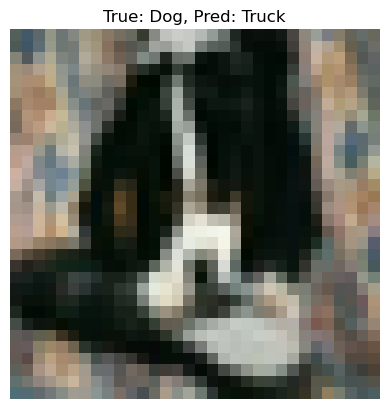

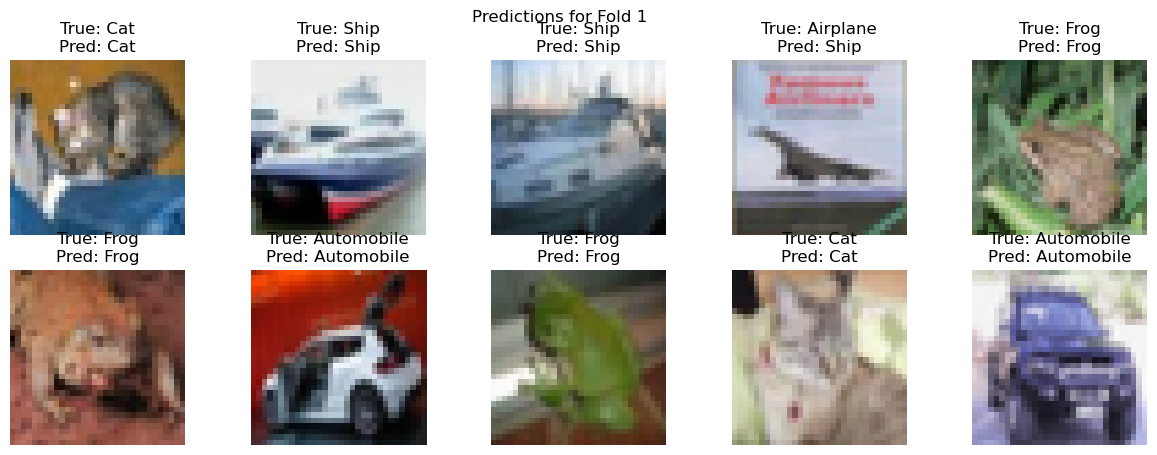

Training fold 2...
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 54ms/step - accuracy: 0.2432 - f1_score: 0.5419 - loss: 2.9523 - precision: 0.3599 - recall: 0.0439 - val_accuracy: 0.3966 - val_f1_score: 0.7630 - val_loss: 2.1360 - val_precision: 0.5775 - val_recall: 0.1881 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 56ms/step - accuracy: 0.3596 - f1_score: 0.6964 - loss: 2.2459 - precision: 0.5466 - recall: 0.1203 - val_accuracy: 0.4081 - val_f1_score: 0.7229 - val_loss: 2.1971 - val_precision: 0.5638 - val_recall: 0.2918 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 56ms/step - accuracy: 0.4208 - f1_score: 0.7778 - loss: 1.9804 - precision: 0.6163 - recall: 0.2007 - val_accuracy: 0.4818 - val_f1_score: 0.8965 - val_loss: 1.8478 - val_precision: 0.6425 - val_recall: 0.2894 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 56ms/step - accuracy: 0.4638 - f1_score: 0.7578 - loss: 1.8426 - precision: 0.6451 - recall: 0.2537 - val_accuracy: 0.5316 - 

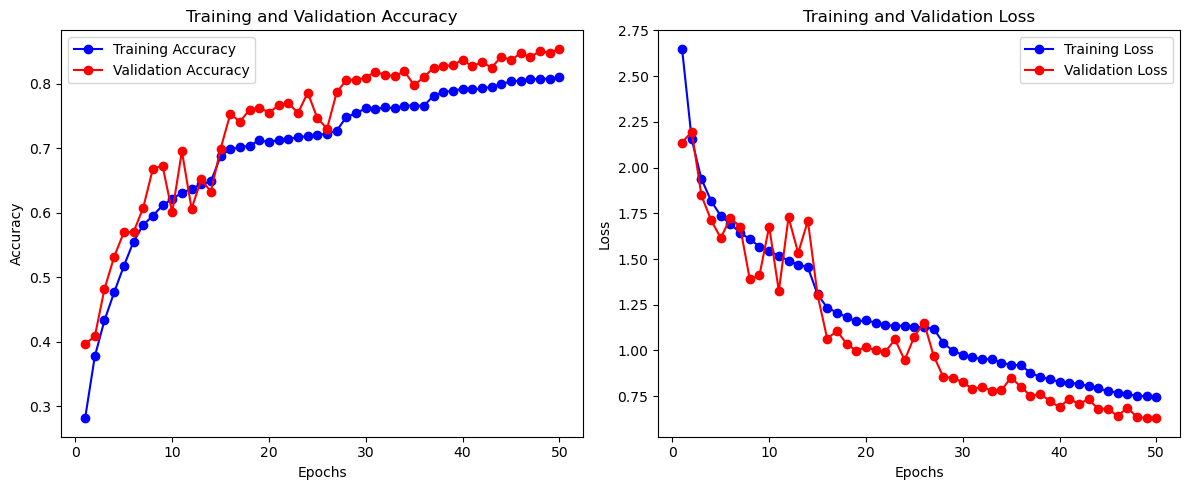

Test Loss: 0.6538127660751343
Test Accuracy: 0.8427000045776367
Test Precision: 0.8802162408828735
Test Recall: 0.8141999840736389
Test F1-score: 0.9589325785636902


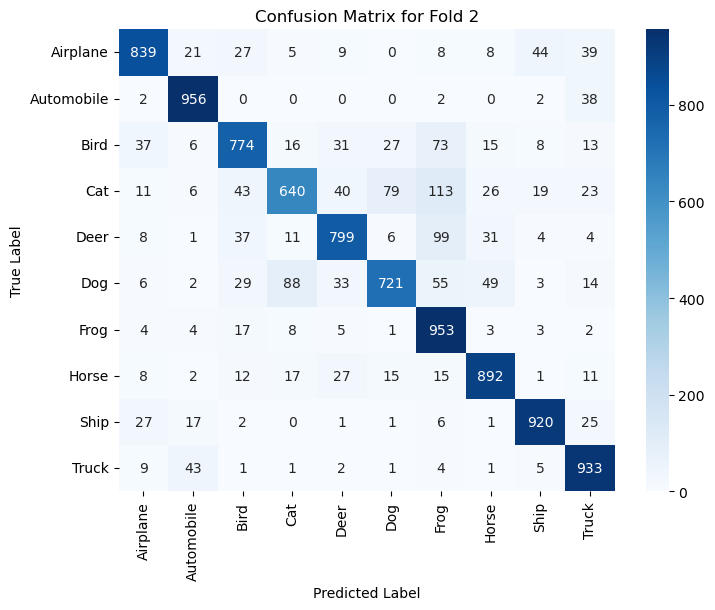

Classification Report for Fold 2:
              precision    recall  f1-score   support

    Airplane       0.88      0.84      0.86      1000
  Automobile       0.90      0.96      0.93      1000
        Bird       0.82      0.77      0.80      1000
         Cat       0.81      0.64      0.72      1000
        Deer       0.84      0.80      0.82      1000
         Dog       0.85      0.72      0.78      1000
        Frog       0.72      0.95      0.82      1000
       Horse       0.87      0.89      0.88      1000
        Ship       0.91      0.92      0.92      1000
       Truck       0.85      0.93      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

Sample Image Prediction for Fold 2:
True Label: Airplane, Predicted Label: Airplane


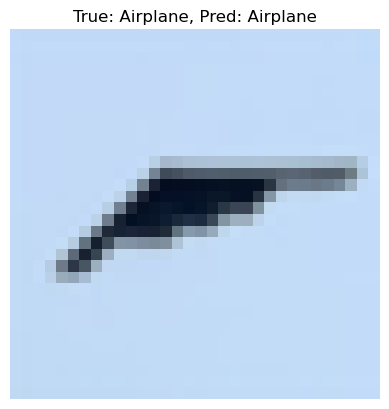

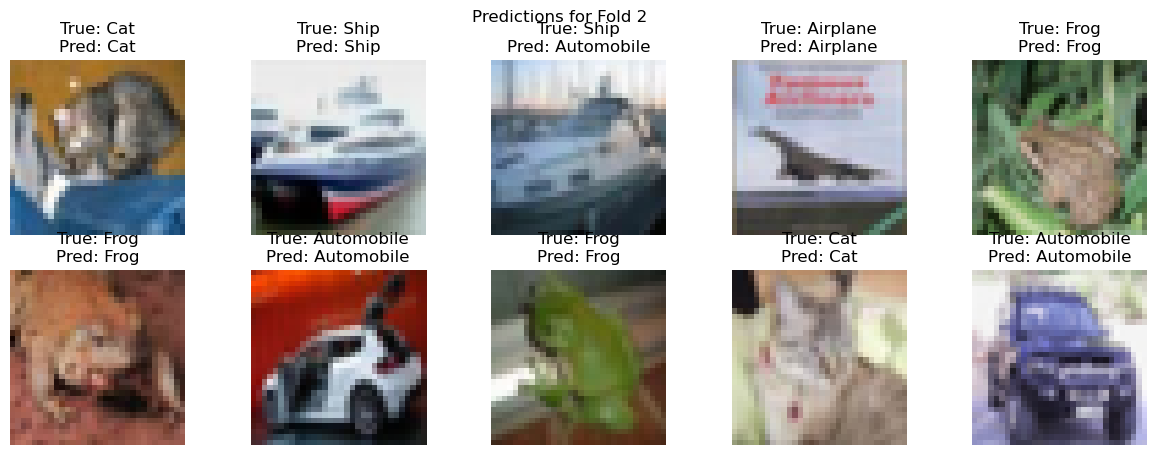

Training fold 3...
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 64s 62ms/step - accuracy: 0.2293 - f1_score: 0.5217 - loss: 3.0254 - precision: 0.3307 - recall: 0.0377 - val_accuracy: 0.3306 - val_f1_score: 0.3486 - val_loss: 2.3200 - val_precision: 0.5237 - val_recall: 0.1531 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - accuracy: 0.3524 - f1_score: 0.6534 - loss: 2.2750 - precision: 0.5502 - recall: 0.1218 - val_accuracy: 0.3709 - val_f1_score: 0.6275 - val_loss: 2.1333 - val_precision: 0.5314 - val_recall: 0.2114 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 63ms/step - accuracy: 0.4191 - f1_score: 0.7732 - loss: 1.9707 - precision: 0.6168 - recall: 0.1923 - val_accuracy: 0.4486 - val_f1_score: 0.7811 - val_loss: 1.9552 - val_precision: 0.6322 - val_recall: 0.2819 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.4747 - f1_score: 0.8093 - loss: 1.8471 - precision: 0.6591 - recall: 0.2626 - val_accuracy: 0.4162 - 

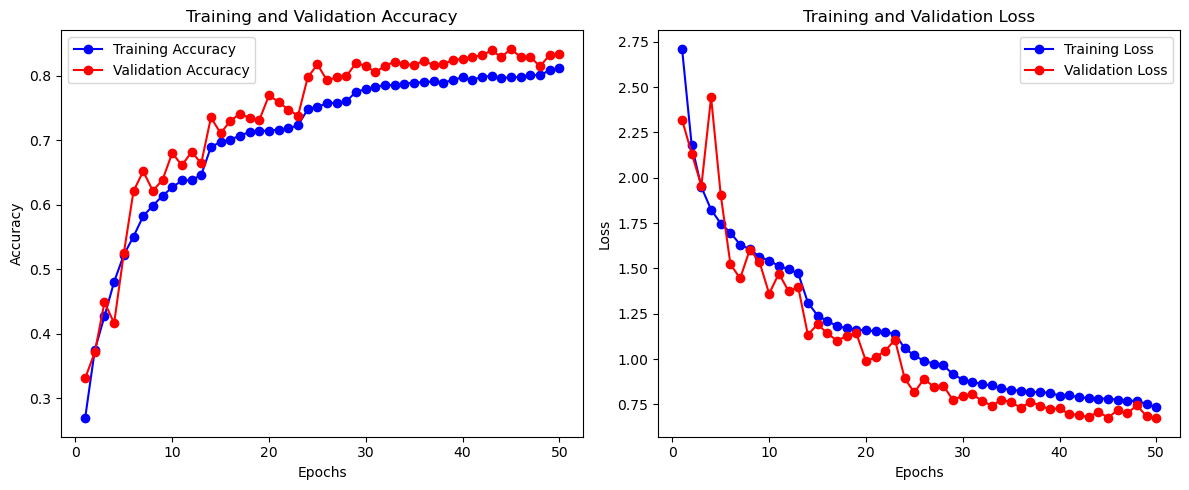

Test Loss: 0.6854660511016846
Test Accuracy: 0.8355000019073486
Test Precision: 0.8677384853363037
Test Recall: 0.8095999956130981
Test F1-score: 0.9583221673965454


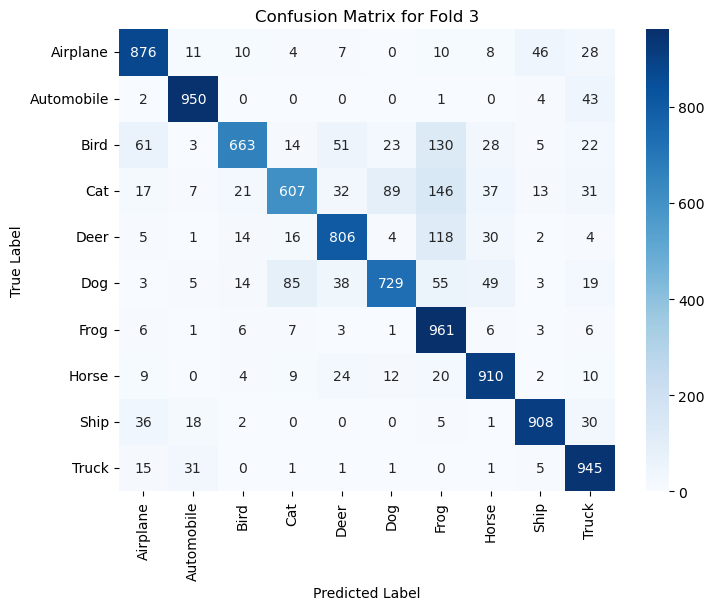

Classification Report for Fold 3:
              precision    recall  f1-score   support

    Airplane       0.85      0.88      0.86      1000
  Automobile       0.93      0.95      0.94      1000
        Bird       0.90      0.66      0.76      1000
         Cat       0.82      0.61      0.70      1000
        Deer       0.84      0.81      0.82      1000
         Dog       0.85      0.73      0.78      1000
        Frog       0.66      0.96      0.79      1000
       Horse       0.85      0.91      0.88      1000
        Ship       0.92      0.91      0.91      1000
       Truck       0.83      0.94      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.83     10000

Sample Image Prediction for Fold 3:
True Label: Ship, Predicted Label: Ship


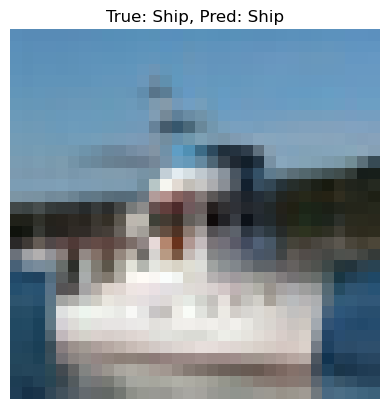

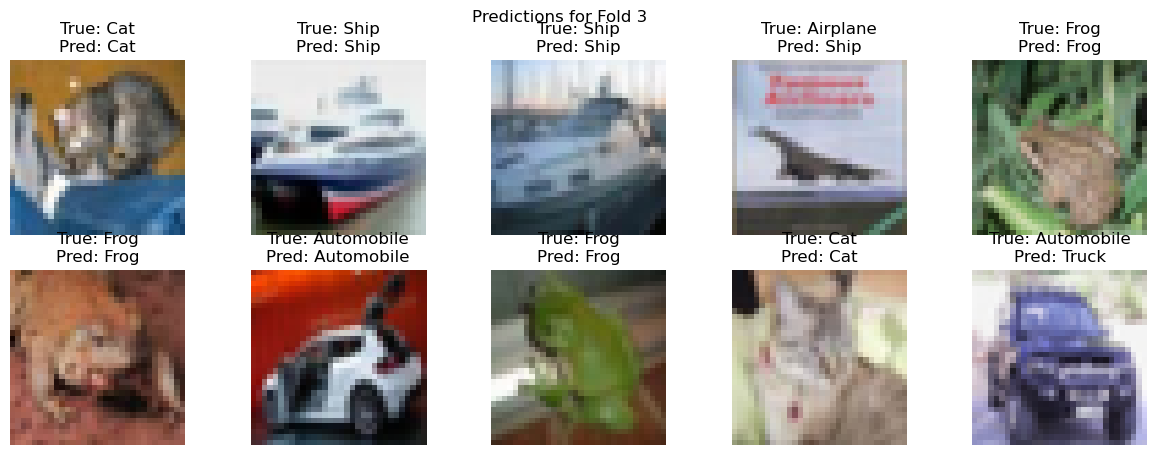

Training fold 4...
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 69ms/step - accuracy: 0.2334 - f1_score: 0.5282 - loss: 2.9711 - precision: 0.3566 - recall: 0.0478 - val_accuracy: 0.3586 - val_f1_score: 0.6509 - val_loss: 2.2468 - val_precision: 0.5890 - val_recall: 0.1386 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.3592 - f1_score: 0.7115 - loss: 2.2646 - precision: 0.5627 - recall: 0.1256 - val_accuracy: 0.3345 - val_f1_score: 0.6375 - val_loss: 2.4723 - val_precision: 0.4737 - val_recall: 0.1911 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.4181 - f1_score: 0.7397 - loss: 2.0040 - precision: 0.6236 - recall: 0.1966 - val_accuracy: 0.4760 - val_f1_score: 0.8676 - val_loss: 2.0138 - val_precision: 0.6284 - val_recall: 0.3485 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.4743 - f1_score: 0.7976 - loss: 1.8539 - precision: 0.6706 - recall: 0.2728 - val_accuracy: 0.5753 - 

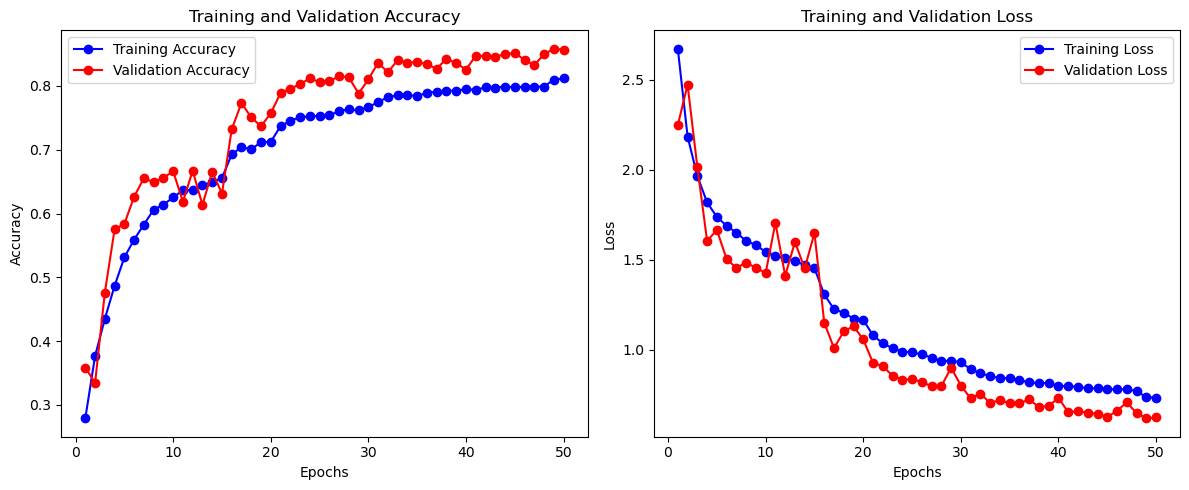

Test Loss: 0.6610829830169678
Test Accuracy: 0.842199981212616
Test Precision: 0.8752155303955078
Test Recall: 0.8122000098228455
Test F1-score: 0.9492753148078918


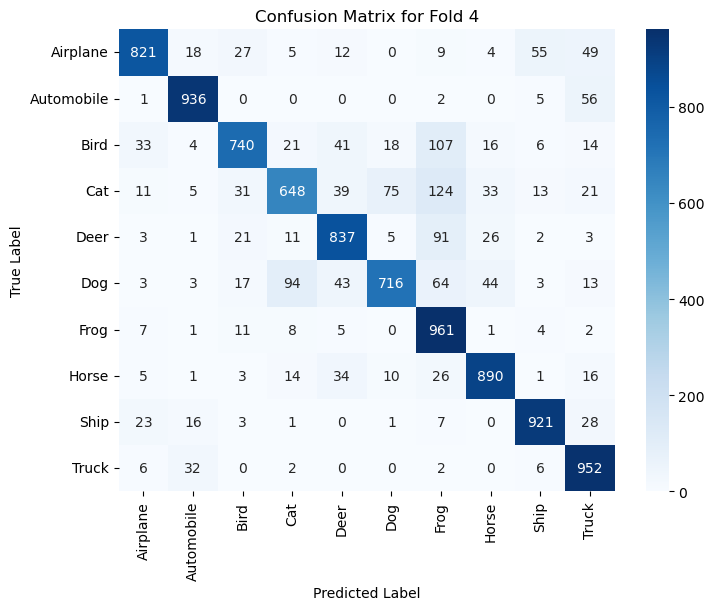

Classification Report for Fold 4:
              precision    recall  f1-score   support

    Airplane       0.90      0.82      0.86      1000
  Automobile       0.92      0.94      0.93      1000
        Bird       0.87      0.74      0.80      1000
         Cat       0.81      0.65      0.72      1000
        Deer       0.83      0.84      0.83      1000
         Dog       0.87      0.72      0.78      1000
        Frog       0.69      0.96      0.80      1000
       Horse       0.88      0.89      0.88      1000
        Ship       0.91      0.92      0.91      1000
       Truck       0.82      0.95      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

Sample Image Prediction for Fold 4:
True Label: Ship, Predicted Label: Ship


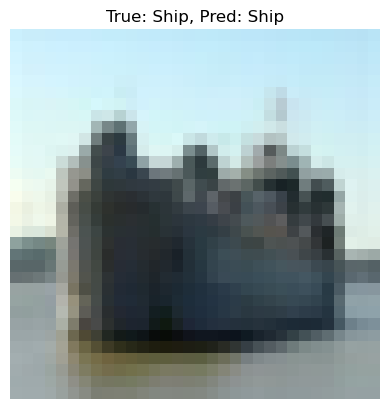

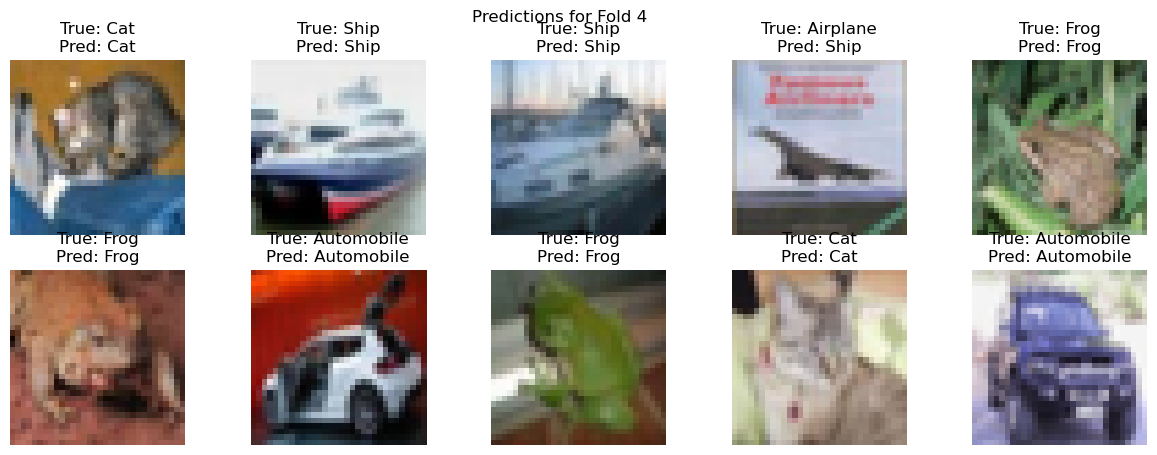

Training fold 5...
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step - accuracy: 0.2389 - f1_score: 0.4969 - loss: 3.0240 - precision: 0.3503 - recall: 0.0478 - val_accuracy: 0.3241 - val_f1_score: 0.6010 - val_loss: 2.3752 - val_precision: 0.4544 - val_recall: 0.1663 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - accuracy: 0.3634 - f1_score: 0.7204 - loss: 2.2659 - precision: 0.5695 - recall: 0.1279 - val_accuracy: 0.4214 - val_f1_score: 0.7768 - val_loss: 2.0400 - val_precision: 0.5642 - val_recall: 0.2747 - learning_rate: 0.0010
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 60ms/step - accuracy: 0.4290 - f1_score: 0.7738 - loss: 1.9901 - precision: 0.6253 - recall: 0.2124 - val_accuracy: 0.4836 - val_f1_score: 0.7976 - val_loss: 1.8163 - val_precision: 0.6501 - val_recall: 0.3072 - learning_rate: 0.0010
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - accuracy: 0.4767 - f1_score: 0.8158 - loss: 1.8502 - precision: 0.6629 - recall: 0.2769 - val_accuracy: 0.5709 - 

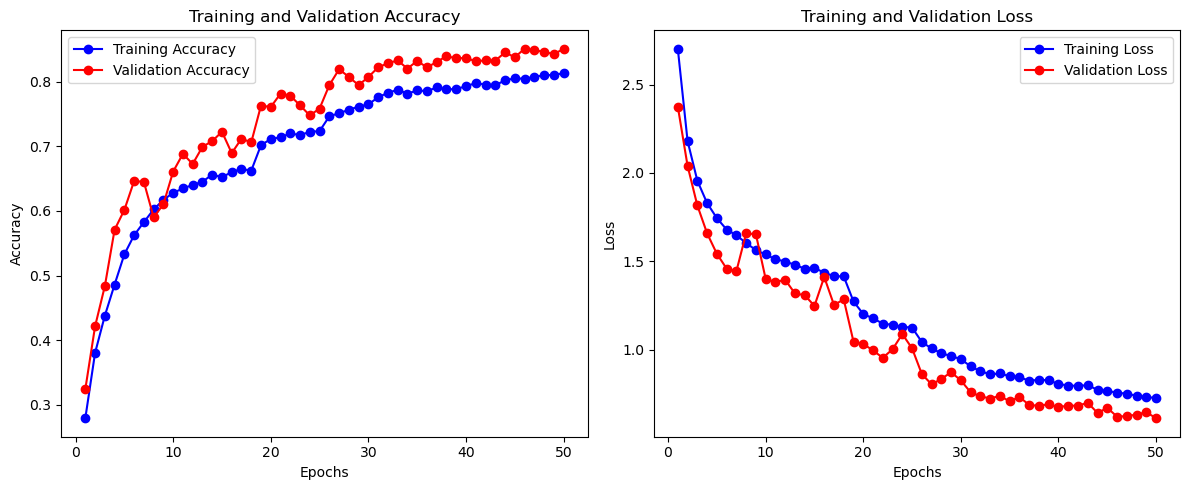

Test Loss: 0.6346482634544373
Test Accuracy: 0.8460000157356262
Test Precision: 0.8824481964111328
Test Recall: 0.8174999952316284
Test F1-score: 0.9573560953140259


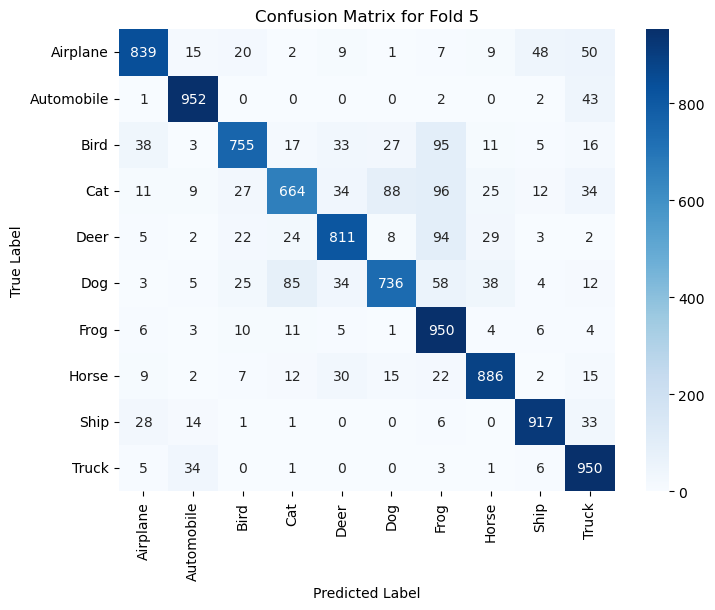

Classification Report for Fold 5:
              precision    recall  f1-score   support

    Airplane       0.89      0.84      0.86      1000
  Automobile       0.92      0.95      0.93      1000
        Bird       0.87      0.76      0.81      1000
         Cat       0.81      0.66      0.73      1000
        Deer       0.85      0.81      0.83      1000
         Dog       0.84      0.74      0.78      1000
        Frog       0.71      0.95      0.81      1000
       Horse       0.88      0.89      0.88      1000
        Ship       0.91      0.92      0.91      1000
       Truck       0.82      0.95      0.88      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000

Sample Image Prediction for Fold 5:
True Label: Deer, Predicted Label: Deer


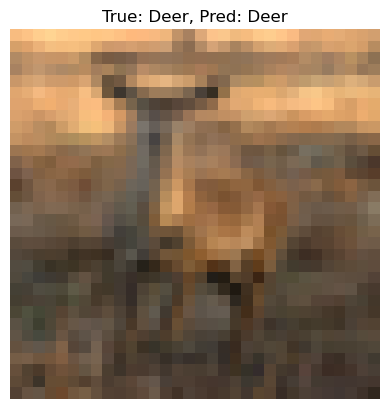

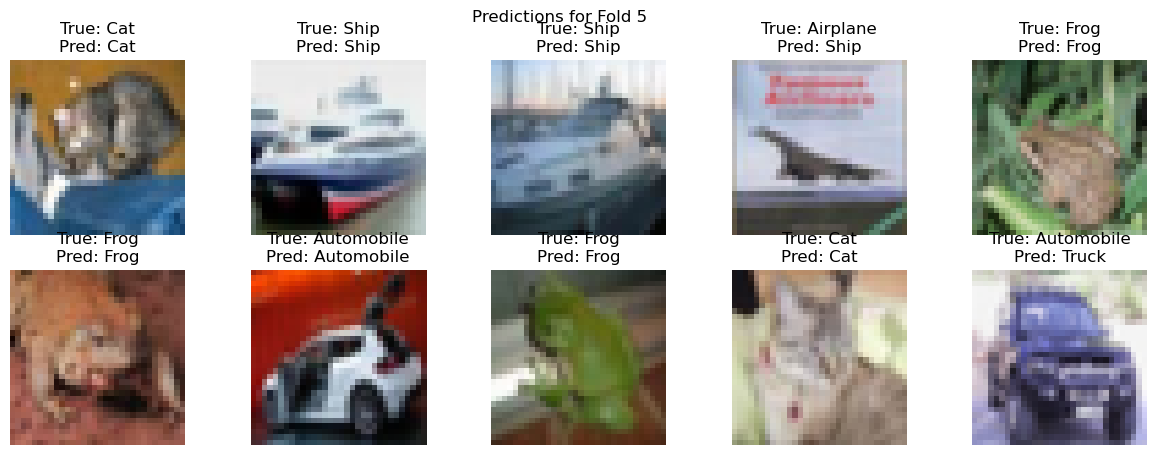

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Function to plot training and validation metrics
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss from model training history.
    """
    # Extract metrics from the history object
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(accuracy) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, fold):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix for Fold {fold + 1}")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot images with predictions and true labels
def plot_predictions(X, y_true, y_pred, class_names, fold, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(X[i])
        plt.title(f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}")
        plt.axis('off')
    plt.suptitle(f"Predictions for Fold {fold + 1}")
    plt.show()

# Stratified K-Fold Cross-Validation
for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(X_train, y_train_class)):
    print(f"Training fold {fold + 1}...")
    
    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
    y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]

    # Create the CNN model
    cnn = create_model()

    # Train the model
    history = cnn.fit(
        datagen.flow(X_train_fold, y_train_fold, batch_size=32),
        epochs=50,
        steps_per_epoch=len(X_train_fold) // 32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop, lr_scheduler]
    )

    # Plot training history
    plot_training_history(history)
    
    # Evaluate on the test set after each fold
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = cnn.evaluate(X_test, y_test, verbose=0)
    
    # Print the evaluation results
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test F1-score: {test_f1}")

    # Confusion matrix and classification report
    y_test_class = np.argmax(y_test, axis=1)
    y_pred = cnn.predict(X_test, verbose=0)
    y_pred_class = np.argmax(y_pred, axis=1)

    # Confusion matrix
    plot_confusion_matrix(y_test_class, y_pred_class, fold)
    
    # Classification report
    report = classification_report(y_test_class, y_pred_class, target_names=class_names)
    print(f"Classification Report for Fold {fold + 1}:\n{report}")

    # Predict one image
    sample_index = np.random.randint(0, len(X_test))  # Randomly select one test image
    sample_image = X_test[sample_index]
    sample_true_label = y_test_class[sample_index]
    sample_pred_label = np.argmax(cnn.predict(np.expand_dims(sample_image, axis=0), verbose=0))
    print(f"Sample Image Prediction for Fold {fold + 1}:")
    print(f"True Label: {class_names[sample_true_label]}, Predicted Label: {class_names[sample_pred_label]}")

    # Plot the image
    plt.imshow(sample_image)
    plt.title(f"True: {class_names[sample_true_label]}, Pred: {class_names[sample_pred_label]}")
    plt.axis('off')
    plt.show()

    # Plot predictions for the first X test images
    plot_predictions(X_test[:10], y_test_class[:10], y_pred_class[:10], class_names, fold, num_images=10)
